In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization

In [ ]:
from IPython.display import FileLinks, FileLink
FileLinks(r'/kaggle/working/')
#FileLink(r'./Midterm_Model.h5')

In [ ]:
import shutil
import os 
#shutil.rmtree("/kaggle/working/lr0.0001_epochs220")
#os.remove('./MyModel.h5')
#os.remove('./lr0.0001_epochs220.h5')

In [ ]:
train_inputImg = []
train_inputImg.append(pd.read_csv('../input/cephalometric-landmarks/train_senior.csv', delimiter=','))
train_inputImg.append(pd.read_csv('../input/cephalometric-landmarks/test1_senior.csv', delimiter=','))

w = 20
train_images = []
masks = []
train_masks = []

for csv_file in train_inputImg:
    for row in csv_file.values:
        img_landmarks = list(row)

        image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + img_landmarks[0], 0) / 255
        Mask_Image = np.zeros((image.shape[0],image.shape[1],1))
        
        for i in range(1,38,2):
            x = img_landmarks[i]
            y = img_landmarks[i+1]
            Mask_Image[y-w:y+w , x-w:x+w ,0] = 1
        
        masks.append(Mask_Image)

        new_image = cv2.resize(image,(256,256))
        new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
        train_images.append(new_image)

        resize_mask=cv2.resize(Mask_Image,(256,256))
        train_masks.append(resize_mask)

size=new_image.shape
print(size)
print (train_masks[0].shape)
plt.subplot(121)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(122)
plt.imshow(train_masks[0], cmap='gray')

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

val_test_inputImg = pd.read_csv('../input/cephalometric-landmarks/test2_senior.csv', delimiter=',')

val_images = []
val_masks_orig = []
val_masks = []

test_images = []
test_masks_orig = []
test_masks = []

count = 1

for row in val_test_inputImg.values:
    img_landmarks = list(row)

    image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + img_landmarks[0], 0) / 255
    Mask_Image = np.zeros((image.shape[0],image.shape[1],1))
    
    for i in range(1,38,2):
        x = img_landmarks[i]
        y = img_landmarks[i+1]
        Mask_Image[y-w:y+w , x-w:x+w ,0] = 1
         

    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    resize_mask=cv2.resize(Mask_Image,(256,256))
    
    if count <= 50:
        val_images.append(new_image)
        val_masks_orig.append(Mask_Image)
        val_masks.append(resize_mask)
    else:
        test_images.append(new_image)
        test_masks_orig.append(Mask_Image)
        test_masks.append(resize_mask)
    
    count += 1
    
size=new_image.shape
print(size)
print (val_masks[0].shape)
print(val_images[0].shape)
plt.subplot(221)
plt.imshow(val_images[0], cmap='gray')
plt.title("Validation")
plt.subplot(222)
plt.imshow(val_masks[0], cmap='gray')

plt.subplot(223)
plt.imshow(test_images[0], cmap='gray')
plt.title("Test")
plt.subplot(224)
plt.imshow(test_masks[0], cmap='gray')

In [ ]:
train_images_stacked = np.stack(train_images, axis=0)
train_masks_stacked = np.stack(train_masks, axis=0)

val_images_stacked = np.stack(val_images, axis=0)
val_masks_stacked = np.stack(val_masks, axis=0)
val_data = (val_images_stacked, val_masks_stacked)

In [ ]:
print(train_images_stacked.shape)
print(train_masks_stacked.shape)

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, output=False):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = BatchNormalization()(conv)
        
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    if not output:
        conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
        conv = BatchNormalization()(conv)
    
    return conv

In [ ]:
def unet_model(input_size, n_filters=64, n_classes=2):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8, False)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4, False)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2, False)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters, True)

    #conv9 = Conv2D(n_filters,
    #             3,
    #             activation='relu',
    #             padding='same',
    #            kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, kernel_size=1, activation='sigmoid', padding='same')(ublock9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
epsilon = 1e-7
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / ( K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)
    return dice

In [ ]:
def dice_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    return 1 - dice

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
checkpoint_filepath = '/kaggle/working/checkpoint_20channels'
checkpoint_20channels = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_dice_coeff',
    save_best_only=True)

In [ ]:
print(size)
unet = unet_model(size, n_classes=1)

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=dice_loss,
              metrics=dice_coeff)

In [ ]:
model_history = unet.fit(train_images_stacked, train_masks_stacked, batch_size = 32, epochs=200, validation_data=val_data, callbacks=[reduce_lr])

In [ ]:
unet.save('Midterm_Model.h5')

In [ ]:
unet.save('Midterm_Model')

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(model_history.history['loss'])
ax1.plot(model_history.history['val_loss'])
ax1.legend(['Training loss', 'val_loss'])

ax2.plot(model_history.history['val_dice_coeff'])
ax2.plot(model_history.history['dice_coeff'])
ax2.legend(['val_dice_coeff', 'dice_coeff'])

In [ ]:
test_images_stacked = np.stack(test_images, axis=0)
test_masks_stacked = np.stack(test_masks, axis=0)

In [ ]:
pred_masks = unet.predict(test_images_stacked)

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(pred_masks[i-1], cmap='gray')

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
idx = 2
test_im_gray = test_images_stacked[idx]   # dimension (256, 256, 1)
test_im_gray_convert = test_im_gray[:,:,0].astype(np.float32) # cv2 accepts dimension(256,256) and float32
# convert to RGB
test_im_rgb = cv2.cvtColor(test_im_gray_convert, cv2.COLOR_GRAY2RGB) 
print(test_im_rgb.shape)
plt.imshow(test_im_rgb)

In [ ]:
print(pred_masks.shape)
print(pred_masks[0].shape)
print(pred_masks[0][0].shape)
print(pred_masks[0][:,:,0].shape)

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

im_copy = test_im_rgb.copy()

test_im_rgb[:,:,1] = test_im_rgb[:,:,1] + test_masks[idx]
maxValue1 = np.amax(test_im_rgb)
minValue1 = np.amin(test_im_rgb)
print("max: ", maxValue1)
print("min: ", minValue1)
print("Uniqueeee1: ",np.unique(test_im_rgb))
plt.subplot(231)
plt.imshow(test_im_rgb/maxValue1)
plt.title("True")


plt.subplot(232)
plt.imshow(test_im_rgb)
plt.title("True w/o scaling ")

plt.subplot(233)
plt.imshow(test_masks[idx], cmap='gray')
plt.title("True Mask")

im_copy[:,:,0] = im_copy[:,:,0] + pred_masks[idx][:,:,0]
maxValue2 = np.amax(im_copy)
minValue2 = np.amin(im_copy)
print("max: ", maxValue2)
print("min: ", minValue2)
print("Uniqueeee2: ",np.unique(im_copy))
plt.subplot(234)
plt.imshow(im_copy/maxValue2)
plt.title("Predicted")

plt.subplot(235)
plt.imshow(im_copy)
plt.title("Predicted w/o scaling ")

plt.subplot(236)
plt.imshow(pred_masks[idx], cmap='gray')
plt.title("Predicted Mask")

In [ ]:
plt.subplot(221)
plt.imshow(test_im_rgb)
plt.title("True")

plt.subplot(222)
plt.imshow(im_copy)
plt.title("Predicted")

plt.subplot(223)
plt.imshow(test_masks[idx], cmap='gray')
plt.title("True Mask")

plt.subplot(224)
plt.imshow(pred_masks[idx], cmap='gray')
plt.title("Predicted Mask")

In [ ]:
resized = cv2.resize(test_im_rgb, (1935,2400))
plt.imshow(resized)

In [ ]:
origi_img = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/386.jpg') / 255
print(origi_img.shape)
print(test_masks_orig[0].shape)

In [ ]:
origi_img[:,:,0] = origi_img[:,:,0] + test_masks_orig[idx][:,:,0]
plt.imshow(origi_img)

In [ ]:
im_copy_resized = cv2.resize(im_copy, (1935,2400))

In [ ]:


plt.subplot(121)
plt.imshow(resized)
plt.title("True")

# plt.subplot(132)
# plt.imshow(origi_img)
# plt.title("original")

plt.subplot(122)
plt.imshow(im_copy_resized)
plt.title("Predicted")

In [ ]:
max_6 = test_images_stacked[6]
min_5 = test_images_stacked[5]
mid_18 = test_images_stacked[18]

max_true_mask = test_masks_stacked[6]
min_true_mask = test_masks_stacked[5]
mid_true_mask = test_masks_stacked[18]


max_pred_mask = pred_masks[6]
min_pred_mask = pred_masks[5]
mid_pred_mask = pred_masks[18]

In [ ]:
def convertRGB(image):
    im_gray_convert = image[:,:,0].astype(np.float32) # cv2 accepts dimension(256,256) and float32
    # convert to RGB
    im_rgb = cv2.cvtColor(im_gray_convert, cv2.COLOR_GRAY2RGB)
    return im_rgb

In [ ]:
def drawTwoMasks(image, idx):
    image[:,:,0] = image[:,:,0] + test_masks[idx]
    image[:,:,1] = image[:,:,1] + pred_masks[idx][:,:,0]
    return image

In [ ]:
max_6 = convertRGB(max_6)
max_6.shape

In [ ]:
max_6 = drawTwoMasks(max_6,6)
plt.imshow(max_6)

In [ ]:
min_5 = convertRGB(min_5)
min_5 = drawTwoMasks(min_5,5)

mid_18 = convertRGB(mid_18)
mid_18 = drawTwoMasks(mid_18,18)

In [ ]:
np.unique(test_masks[1] == test_masks_stacked[1])

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(131)
plt.imshow(max_6, cmap='gray')
plt.title("Max Error")

plt.subplot(132)
plt.imshow(mid_18, cmap='gray')
plt.title("Mid Error")

plt.subplot(133)
plt.imshow(min_5, cmap='gray')
plt.title("Min Error")

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
max_6 = convertRGB(test_images_stacked[6])
min_5 = convertRGB(test_images_stacked[5])
mid_18 = convertRGB(test_images_stacked[18])

max_6_copy = max_6.copy()
min_5_copy = min_5.copy()
mid_18_copy = mid_18.copy()

max_true_mask = test_masks_stacked[6]
min_true_mask = test_masks_stacked[5]
mid_true_mask = test_masks_stacked[18]

max_pred_mask = pred_masks[6]
min_pred_mask = pred_masks[5]
mid_pred_mask = pred_masks[18]

max_6[:,:,1] = max_6[:,:,1] + max_true_mask
min_5[:,:,1] = min_5[:,:,1] + min_true_mask
mid_18[:,:,1] = mid_18[:,:,1] + mid_true_mask

max_6_copy[:,:,0] = max_6_copy[:,:,0] + max_pred_mask[:,:,0]
min_5_copy[:,:,0] = min_5_copy[:,:,0] + min_pred_mask[:,:,0]
mid_18_copy[:,:,0] = mid_18_copy[:,:,0] + mid_pred_mask[:,:,0]

In [ ]:
plt.subplot(231)
plt.imshow(max_6)
plt.title("Max Error: True")

plt.subplot(232)
plt.imshow(mid_18)
plt.title("Mid Error: True")

plt.subplot(233)
plt.imshow(min_5)
plt.title("Min Error: True")

plt.subplot(234)
plt.imshow(max_6_copy)
plt.title("Max Error: Pred")

plt.subplot(235)
plt.imshow(mid_18_copy)
plt.title("Mid Error: Pred")

plt.subplot(236)
plt.imshow(min_5_copy, cmap='gray')
plt.title("Min Error: Pred")

In [ ]:
unet.evaluate(test_images_stacked, test_masks_stacked)

In [ ]:
plt.subplot(321)
plt.imshow(max_6)
plt.title("Max Error: True")

plt.subplot(322)
plt.imshow(max_6_copy)
plt.title("Max Error: Pred")

plt.subplot(323)
plt.imshow(mid_18)
plt.title("Mid Error: True")

plt.subplot(324)
plt.imshow(mid_18_copy)
plt.title("Mid Error: Pred")

plt.subplot(325)
plt.imshow(min_5)
plt.title("Min Error: True")

plt.subplot(326)
plt.imshow(min_5_copy)
plt.title("Min Error: Pred")

# Stage 2: 20 channels Gaussian Mask 
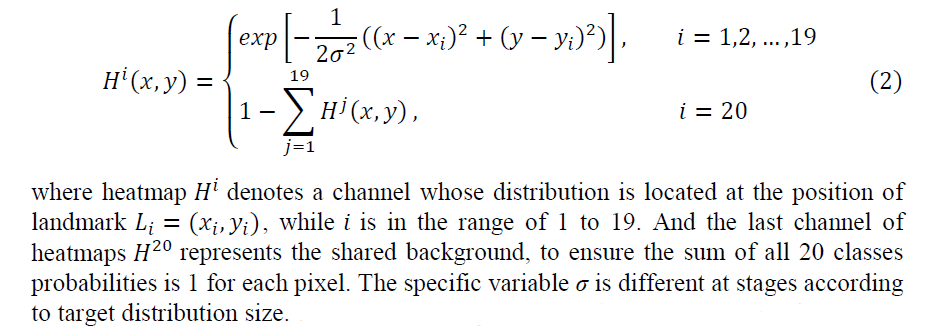

In [ ]:
# Fill a 2D array with gaussian distribution  --> (1935,2400)  ---> (width,height)
# Note: in code, the order is (height, width) --> (rows, columns) --> (y,x)
# consider center to be (1000,1000) ---> (Xi,Yi)
import time
Xi = 1000
Yi = 1000
sigma = 10
channel = np.zeros((2400,1935))
s1 = time.time()
for y in range(2400):
    for x in range(1935):
        channel[y,x] = np.exp(((x-Xi)**2 + (y-Yi)**2) / (-2* sigma**2))
e1 = time.time()
print(np.max(channel))
print(channel.shape)
print("Time: ", e1-s1)

In [ ]:
x = np.arange(1935).reshape(1,1935)
y = np.arange(2400).reshape(2400,1)

s2 = time.time()
channel2 = np.exp((y-Yi)**2/(-2*sigma**2)) * np.exp((x-Xi)**2/(-2*sigma**2)) 
e2 = time.time()
print(np.max(channel2))
print("Time: ", e2-s2)
print(channel2.shape)

In [ ]:
np.unique(channel == channel2)

In [ ]:
print(channel[Yi,Xi],'  ', channel2[Yi,Xi])
print(channel[Yi+1,Xi+1], '  ', channel2[Yi+1,Xi+1])
print(channel[Yi+1,Xi], '  ', channel2[Yi+1,Xi])
print(channel[Yi,Xi+1], '  ', channel2[Yi,Xi+1])
unq_channel = np.unique(channel)
unq_channel2 = np.unique(channel2)
print(unq_channel, len(unq_channel))
print(unq_channel2, len(unq_channel2))
print(unq_channel == unq_channel2)

In [ ]:
channel3 = np.zeros((2400,1935))
s3 = time.time()
for y in range(2400):
    if y <= 1934 :
        for x in range(y,1935):
            channel3[y,x] = np.exp(((x-Xi)**2 + (y-Yi)**2) / (-2* sigma**2))
            channel3[x,y] = np.exp(((x-Xi)**2 + (y-Yi)**2) / (-2* sigma**2))
    else:
        for x in range(1935):
            channel3[y,x] = np.exp(((x-Xi)**2 + (y-Yi)**2) / (-2* sigma**2))
e3 = time.time()
print(np.max(channel3))
print(channel3.shape)
print("Time: ", e1-s1)

In [ ]:
print(np.unique(channel == channel3))
print(channel[Yi,Xi],'  ', channel3[Yi,Xi])
print(channel[Yi+1,Xi+1], '  ', channel3[Yi+1,Xi+1])
print(channel[Yi+1,Xi], '  ', channel3[Yi+1,Xi])
print(channel[Yi,Xi+1], '  ', channel3[Yi,Xi+1])
unq_channel = np.unique(channel)
unq_channel3 = np.unique(channel3)
print(unq_channel, len(unq_channel))
print(unq_channel3, len(unq_channel3))
print(unq_channel == unq_channel3)

In [ ]:
plt.subplot(121)
plt.imshow(channel, cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.imshow(channel2, cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(cv2.resize(channel,(256,256)), cmap='gray')
plt.colorbar()

In [ ]:
# Fill a 2D array with gaussian distribution  --> (1935,2400)  ---> (width,height)
# Note: in code, the order is (height, width) --> (rows, columns) --> (y,x)
# consider center to be (1000,1000) ---> (Xi,Yi)
import time
Xi = 100
Yi = 50
sigma = 2
channel = np.zeros((256,256))
s1 = time.time()
for y in range(256):
    for x in range(256):
        channel[y,x] = np.exp(((x-Xi)**2 + (y-Yi)**2) / (-2* sigma**2))
e1 = time.time()
print(np.max(channel))
print(channel.shape)
print("Time: ", e1-s1)

plt.imshow(channel, cmap='gray')
plt.colorbar()

In [ ]:
mmtrue = np.zeros((8,5))
mmtrue[6,3] = 1
print(mmtrue)

print(cv2.resize(mmtrue, (3,3)))

In [ ]:
mmtrue = np.zeros((5,5))
mmtrue[3,3] = 1
print(mmtrue)

print(cv2.resize(mmtrue, (3,3)))

In [ ]:
img = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/001.jpg')
l1_centre = (835,996)
img = cv2.circle(img, l1_centre, 20, (255,0,0), -1)
plt.imshow(img)
img.shape

In [ ]:
img = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/001.jpg')
l1_centre = (835*256//1935,996*256//2400)
print(l1_centre[0])
img = cv2.resize(img, (256,256))
img = cv2.circle(img, l1_centre, 3, (255,0,0), -1)
plt.imshow(img)
img.shape

In [ ]:
d = np.array([[1,2],[3,4]])
s = np.array([[5,6],[7,8]])
f = np.array([[9,10],[11,12]])
listt = [d,s,f]
gg = np.stack(listt, axis=-1)
print(gg.shape)
print(gg[:,:,-1])

## Create arrays of 20 channels masks for all x-ray images 
### After all the experiments, it was found that the most convenient way was to create channels of masks after resizing to (256,256)

In [ ]:
def create_landmark_channel(Xi, Yi, sigma=2):
    channel = np.zeros((256,256))
    for y in range(256):
        for x in range(256):
            channel[y,x] = np.exp(((x-Xi)**2 + (y-Yi)**2) / (-2* sigma**2))
    
    return channel

In [ ]:
train_inputImg = []
train_inputImg.append(pd.read_csv('../input/cephalometric-landmarks/train_senior.csv', delimiter=','))
train_inputImg.append(pd.read_csv('../input/cephalometric-landmarks/test1_senior.csv', delimiter=','))

sigma = 2
train_images = []
train_masks = []
count = 0
for csv_file in train_inputImg:
    for row in csv_file.values:
        count += 1
        img_landmarks = list(row)

        image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + img_landmarks[0], 0) / 255
        channels_list = []
        background_channel = np.zeros((256,256))
        
        for i in range(1,38,2):
            x = img_landmarks[i]
            y = img_landmarks[i+1]
            ch = create_landmark_channel(x*256//1935,y*256//2400)
            channels_list.append(ch)
            background_channel += ch
        
        background_channel = 1 - background_channel
        channels_list.append(background_channel)
        mask = np.stack(channels_list, axis=-1)
        
        new_image = cv2.resize(image,(256,256))
        new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
        train_images.append(new_image)
        
        train_masks.append(mask)
        print(count)
        
train_images_stacked = np.stack(train_images, axis=0)
train_masks_stacked = np.stack(train_masks, axis=0)

print(train_images_stacked.shape)
print(train_images_stacked[0].shape)
print(train_masks_stacked.shape)
print(train_masks_stacked[0].shape)

In [ ]:
np.save('train_images.npy', train_images_stacked)
np.save('train_masks.npy', train_masks_stacked)

In [ ]:
val_test_inputImg = pd.read_csv('../input/cephalometric-landmarks/test2_senior.csv', delimiter=',')

val_images = []
val_masks = []

test_images = []
test_masks = []

count = 1

for row in val_test_inputImg.values:
    img_landmarks = list(row)
    print(count)
    
    image = cv2.imread('../input/cephalometric-landmarks/cepha400/cepha400/' + img_landmarks[0], 0) / 255
    channels_list = []
    background_channel = np.zeros((256,256))
        
    for i in range(1,38,2):
        x = img_landmarks[i]
        y = img_landmarks[i+1]
        ch = create_landmark_channel(x*256//1935,y*256//2400)
        channels_list.append(ch)
        background_channel += ch
        
    background_channel = 1 - background_channel
    channels_list.append(background_channel)
    mask = np.stack(channels_list, axis=-1) 

    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    
    if count <= 50:
        val_images.append(new_image)
        val_masks.append(mask)
    else:
        test_images.append(new_image)
        test_masks.append(mask)
    
    count += 1
    
val_images_stacked = np.stack(val_images, axis=0)
val_masks_stacked = np.stack(val_masks, axis=0)
val_data = (val_images_stacked, val_masks_stacked)

test_images_stacked = np.stack(test_images, axis=0)
test_masks_stacked = np.stack(test_masks, axis=0)

print("Val images: ", val_images_stacked.shape)
print('Image: ', val_images_stacked[0].shape)
print('Val masks: ', val_masks_stacked.shape)
print('mask: ', val_masks_stacked[0].shape)
print('Test images: ', test_images_stacked.shape)
print('Image: ', test_images_stacked[0].shape)
print('Test masks: ', test_masks_stacked.shape)
print('mask: ', test_masks_stacked[0].shape)

In [ ]:
np.save('val_images.npy', val_images_stacked)
np.save('val_masks.npy', val_masks_stacked)
np.save('test_images.npy', test_images_stacked)
np.save('test_masks.npy', test_masks_stacked)

In [ ]:
def unet_model(input_size, n_filters=64, n_classes=2):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8, False)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4, False)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2, False)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters, True)

    #conv9 = Conv2D(n_filters,
    #             3,
    #             activation='relu',
    #             padding='same',
    #            kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, kernel_size=1, activation='softmax', padding='same')(ublock9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
size = train_images_stacked[0].shape
unet = unet_model(size, n_classes=20)

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=dice_loss,
              metrics=dice_coeff)

In [ ]:
model_history = unet.fit(train_images_stacked, train_masks_stacked, batch_size = 32, epochs=50, validation_data=val_data, callbacks=[reduce_lr, checkpoint_20channels])